# Introduction

In this notebook, I'll be looking to see whether more authoritarian governments are able to better control the happiness of its citizens in the face of a happiness shock, in this case, COVID0-19. I will begin by looking at Happiness Data gathered from the World Happiness Report and then at Democracy Indicators gathered by the Economic Intelligence Unit. 

## Import Relevant Libraries

In [1]:
import pandas as pd
import altair as alt
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import warnings
warnings.filterwarnings('ignore')
from altair_data_server import data_server
alt.data_transformers.register('data_server', data_server)
alt.data_transformers.enable('data_server')


/Users/luciusgao/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


DataTransformerRegistry.enable('data_server')

# Exploratory Data Analysis & Visualization

## Happiness

This data is sourced from the World Happiness Report. The Happiness scores and rankings utilize information from the Gallup World Survey. The scores are based on answers to the most life evaluation address inquired within the survey. This address, known as the Cantril step, asks respondents to think of a step with the most excellent conceivable life for them being a 10 and the most exceedingly bad conceivable life being a and to rate their claim current lives on that scale.

### Import & Clean Happiness Data
* in 2022, Swaziland changed their name to Kingdom of Eswatini
* countries_2021 has Congo (Brazzaville), countries_2020/2019 hve two congos, and countries_2022 has Congo
* countries_2022 has Czechia but all the others say czech republic. 

In [2]:
happiness_path = 'Data/Happiness/'

replaces = {"Eswatini, Kingdom of" : "Kingdom of Eswatini",
            "Swaziland" : "Kingdom of Eswatini",
            "Czech Republic" : "Czechia"
            }

dataframes = []

for filename in os.scandir(happiness_path):
    print("Working on: " + filename.path)

    curr_df = pd.read_csv(filename)

    # some countries have an asterisk next to their name
    curr_df['Country'] = curr_df["Country"].str.replace("*","",regex=True)

    # replace certain country names so it's all uniform
    curr_df['Country'] = curr_df['Country'].replace(replaces)

    # add "_year" after the Happiness Score for columns
    match = re.search(r"\d{4}", filename.path)
    year = match.group(0) if match else None
    curr_df.rename(columns = {"Happiness Score" : "Happiness Score " + year},
                   inplace = True)
    
    # Congo is sometimes split up, so turn it into one row
    congo_rows = curr_df[curr_df['Country'].isin(['Congo (Brazzaville)', 'Congo (Kinshasa)'])]
    if not congo_rows.empty:
        avg_row = congo_rows.mean(numeric_only=True)
        new_row = congo_rows.iloc[0].copy()
        new_row[new_row.index.str.startswith('Happiness Score ')] = avg_row
        # Set the new country name
        new_row['Country'] = 'Congo'
        # Remove the original rows from the DataFrame
        curr_df = curr_df[~curr_df['Country'].isin(['Congo (Brazzaville)', 'Congo (Kinshasa)'])]
        # Add the new row with the average values to the DataFrame
        curr_df = curr_df.append(new_row, ignore_index=True)

    dataframes.append(curr_df)

Working on: Data/Happiness/2020.csv
Working on: Data/Happiness/2021.csv
Working on: Data/Happiness/2022.csv
Working on: Data/Happiness/2019.csv


In [3]:
happiness_df = dataframes[0][['Country']]
for i, df in enumerate(dataframes):
    filtered_columns = df.filter(regex=r"Happiness Score")

    country_happiness_df = pd.concat([df['Country'], filtered_columns], axis=1)

    # Merge the result DataFrame with the country_happiness_df on the 'Country' column
    happiness_df = happiness_df.merge(country_happiness_df, on='Country', how='right')

# Split the DataFrame into the first column and the remaining columns
first_column = happiness_df.iloc[:, 0:1]
remaining_columns = happiness_df.iloc[:, 1:]

# Sort the remaining columns
sorted_remaining_columns = remaining_columns.sort_index(axis=1)

# Concatenate the first column with the sorted remaining columns
happiness_df = pd.concat([first_column, sorted_remaining_columns], axis=1)

happiness_df['Happiness Score 2022'] = happiness_df['Happiness Score 2022'].str.replace(',','.')
happiness_df['Happiness Score 2022'] = pd.to_numeric(happiness_df['Happiness Score 2022'], errors ='ignore').astype(pd.Float64Dtype())

happiness_df.dropna(subset=['Happiness Score 2019', 'Happiness Score 2020',
                            'Happiness Score 2021',	'Happiness Score 2022'],
                    inplace=True)

happiness_df.reset_index(drop=True, inplace=True)
happiness_df

,Country,Happiness Score 2019,Happiness Score 2020,Happiness Score 2021,Happiness Score 2022
0,Finland,7.769,7.8087,7.842,7.821
1,Denmark,7.600,7.6456,7.620,7.636
2,Norway,7.554,7.4880,7.392,7.365
3,Iceland,7.494,7.5045,7.554,7.557
4,Netherlands,7.488,7.4489,7.464,7.415
...,...,...,...,...,...
137,Yemen,3.380,3.5274,3.658,4.197
138,Rwanda,3.334,3.3123,3.415,3.268
139,Tanzania,3.231,3.4762,3.623,3.702
140,Afghanistan,3.203,2.5669,2.523,2.404


There are 142 countries that are consistently in each of the reports, so we will be looking at 142 countries. This isn't all of the countries but it should be enough to give us a measure of what we are looking for. 

### Rank Countries by Happiness Level (Visualization)

The charts present the 'Happiness Score' for each country contained within the happiness_df DataFrame for the respective year. In each of these visualizations, the abscissa represents the 'Happiness Score' whilst the ordinate depicts the countries. Notably, the countries are ordered in a descending fashion according to their happiness scores, from the highest to the lowest. The bars in the chart are color-coded with 'steelblue' to enhance visual distinction. The individual charts are consequently concatenated horizontally, creating an aggregate visualization enabling comparison of happiness scores across countries from year to year. With this arrangement, one can observe if a country's happiness score has ascended, descended, or remained relatively unchanged over the years.

We can see that, in general, the top and bottom ten countries stay largely the same and that most of the changes in happiness over COVID happened to the countries in the middle. This suggests that governments in the top/bottom 10 are fairly consistent in happiness regardless of a happiness shock. 

In [4]:
import altair as alt

# Assuming you have the DataFrame happiness_df

# Create the horizontal bar charts for each year with all countries
chart_2019 = alt.Chart(happiness_df).mark_bar().encode(
    x='Happiness Score 2019:Q',
    y=alt.Y('Country:N', sort='-x'),
    color=alt.value('steelblue'),
    tooltip=[alt.Tooltip("Country"), alt.Tooltip("Happiness Score 2019")]
).properties(
    title='Countries by Happiness Score in 2019',
    width=150,
    height=1500
)

chart_2020 = alt.Chart(happiness_df).mark_bar().encode(
    x='Happiness Score 2020:Q',
    y=alt.Y('Country:N', sort='-x'),
    color=alt.value('steelblue'),
    tooltip=[alt.Tooltip("Country"), alt.Tooltip("Happiness Score 2020")]
).properties(
    title='Countries by Happiness Score in 2020',
    width=150,
    height=1500
)

chart_2021 = alt.Chart(happiness_df).mark_bar().encode(
    x='Happiness Score 2021:Q',
    y=alt.Y('Country:N', sort='-x'),
    color=alt.value('steelblue'),
    tooltip=[alt.Tooltip("Country"), alt.Tooltip("Happiness Score 2021")]
).properties(
    title='Countries by Happiness Score in 2021',
    width=150,
    height=1500
)

chart_2022 = alt.Chart(happiness_df).mark_bar().encode(
    x='Happiness Score 2022:Q',
    y=alt.Y('Country:N', sort='-x'),
    color=alt.value('steelblue'),
    tooltip=[alt.Tooltip("Country"), alt.Tooltip("Happiness Score 2022")]
).properties(
    title='Countries by Happiness Score in 2022',
    width=150,
    height=1500
)

# Concatenate the charts horizontally
concatenated_chart = alt.hconcat(chart_2019, chart_2020, chart_2021, chart_2022)

# Display the concatenated chart
concatenated_chart


alt.HConcatChart(...)

## Democracy

The Democracy Index measures the quality of the democracy in a country and is produced by the Economist Intelligence Unit and published on a yearly basis.

### Import & Clean Democracy Data

In [5]:
democracy_path = 'Data/Democracy/democracy.csv'
dem_df = pd.read_csv(democracy_path)
dem_df = dem_df[dem_df['Year'] >= 2019]
dem_df = dem_df.pivot(index='Entity', columns='Year', values='democracy_eiu')
dem_df.columns = [f'Democracy Score {col}' for col in dem_df.columns]
dem_df.reset_index(inplace=True)
dem_df.rename(columns={'Entity':'Country'}, inplace=True)
dem_df

,Country,Democracy Score 2019,Democracy Score 2020,Democracy Score 2021,Democracy Score 2022
0,Afghanistan,2.850000,2.85000,0.320000,0.320000
1,Africa,4.221200,4.11640,4.071600,4.075000
2,Albania,5.890000,6.08000,6.110000,6.410000
3,Algeria,4.010000,3.77000,3.770000,3.660000
4,Angola,3.720000,3.66000,3.370000,3.960000
...,...,...,...,...,...
169,Vietnam,3.080000,2.94000,2.940000,2.730000
170,World,5.439641,5.36976,5.281377,5.293174
171,Yemen,1.950000,1.95000,1.950000,1.950000
172,Zambia,5.090000,4.86000,5.720000,5.800000


In [6]:
countries = pd.read_csv('Data/GeoJSONs/countries.csv')
countries = set(countries['Country'])

In [7]:
dem_countries = set(dem_df['Country'])

# Find the countries in dem_df that are not in the countries set
countries_not_in_set = dem_countries - countries

print(countries_not_in_set)

{'Djibouti', 'Sudan', 'Europe', 'Syria', 'Eswatini', 'Asia', 'Central African Republic', 'Guinea-Bissau', 'Hong Kong', 'Equatorial Guinea', 'Taiwan', 'North America', 'Cuba', 'Suriname', 'Democratic Republic of Congo', 'North Macedonia', 'Palestine', 'Bhutan', "Cote d'Ivoire", 'Trinidad and Tobago', 'World', 'Guyana', 'Fiji', 'North Korea', 'Burundi', 'Cape Verde', 'Africa', 'Haiti', 'Qatar', 'Oceania', 'Eritrea', 'Angola', 'Papua New Guinea', 'Oman', 'Timor', 'South America'}


In [8]:
replaces = {"Eswatini" : "Kingdom of Eswatini",
            "Palestine" : "Palestinian Territories",
            "Cote d'Ivoire" : "Ivory Coast",
            }

removes = ['World','Qatar','Burundi','Central African Republic',
           'South America','Timor','Sudan','Asia','Guyana','North Macedonia',
           'Guinea-Bissau', 'Cuba','Equatorial Guinea','Bhutan','Suriname',
           'Haiti','Cape Verde','Europe','Syria','Eritrea','Hong Kong',
           'Africa','Papua New Guinea','Oman','North America', 'Angola',
           'Djibouti','North Korea','Fiji', 'Trinidad and Tobago', 'Taiwan', 'Oceania',"Democratic Republic of Congo"]

In [9]:
# Replace values in the 'Entity' column using the replaces dictionary
dem_df['Country'] = dem_df['Country'].replace(replaces)

# Remove rows corresponding to the values in the removes list
dem_df = dem_df[~dem_df['Country'].isin(removes)]

In [10]:
dem_countries = set(dem_df['Country'])

# Find the countries in dem_df that are not in the countries set
countries_not_in_set = dem_countries - countries

print(countries_not_in_set)

set()


In [11]:
# Define the custom function to determine the label based on the democracy score
def get_label(score):
    if 0 <= score <= 4:
        return "Authoritarian"
    elif 4 < score <= 6:
        return "Hybrid Regime"
    elif 6 < score <= 8:
        return "Flawed Democracy"
    elif 8 < score <= 10:
        return "Full Democracy"
    else:
        return "Unknown"

# Apply the custom function to create the label columns
dem_df['2019 Label'] = dem_df['Democracy Score 2019'].apply(get_label)
dem_df['2020 Label'] = dem_df['Democracy Score 2020'].apply(get_label)
dem_df['2021 Label'] = dem_df['Democracy Score 2021'].apply(get_label)
dem_df['2022 Label'] = dem_df['Democracy Score 2022'].apply(get_label)

In [12]:
dem_df

,Country,Democracy Score 2019,Democracy Score 2020,Democracy Score 2021,Democracy Score 2022,2019 Label,2020 Label,2021 Label,2022 Label
0,Afghanistan,2.85,2.85,0.32,0.32,Authoritarian,Authoritarian,Authoritarian,Authoritarian
2,Albania,5.89,6.08,6.11,6.41,Hybrid Regime,Flawed Democracy,Flawed Democracy,Flawed Democracy
3,Algeria,4.01,3.77,3.77,3.66,Hybrid Regime,Authoritarian,Authoritarian,Authoritarian
5,Argentina,7.02,6.95,6.81,6.85,Flawed Democracy,Flawed Democracy,Flawed Democracy,Flawed Democracy
6,Armenia,5.54,5.35,5.49,5.63,Hybrid Regime,Hybrid Regime,Hybrid Regime,Hybrid Regime
...,...,...,...,...,...,...,...,...,...
168,Venezuela,2.88,2.76,2.11,2.23,Authoritarian,Authoritarian,Authoritarian,Authoritarian
169,Vietnam,3.08,2.94,2.94,2.73,Authoritarian,Authoritarian,Authoritarian,Authoritarian
171,Yemen,1.95,1.95,1.95,1.95,Authoritarian,Authoritarian,Authoritarian,Authoritarian
172,Zambia,5.09,4.86,5.72,5.80,Hybrid Regime,Hybrid Regime,Hybrid Regime,Hybrid Regime


### Rank Countries by Democracy Level (Visualization)

Each individual chart corresponds to a distinct year (spanning 2019 to 2022) and illustrates the 'Democracy Score' for each country encapsulated within the dem_df DataFrame for that specific year. In each graph, the x-axis symbolizes the 'Democracy Score', while the y-axis signifies the countries. The countries are organized in descending order according to their democracy scores, from most democratic to least democratic. The bars are color-coded based on an 'Authoritarianism Label'. This layout enables the observer to discern whether a country's democracy score has amplified, diminished, or largely remained unaltered over the considered duration.

Like happiness, the top and bottom ten most/least democratic countries seem to stay the same. We see the most changes in 2020 and 2021, which could have been expected because COVID-19 could have placed more strain on political systems and they might have needed to become more authoritarian to overcome COVID. 

In [13]:
# Create the horizontal bar charts for each year with color encoding based on authoritarianism label
chart_2019 = alt.Chart(dem_df).mark_bar().encode(
    x='Democracy Score 2019:Q',
    y=alt.Y('Country:N', sort='-x'),
    color=alt.Color('2019 Label:N', scale=alt.Scale(scheme='set1')),
    tooltip=[alt.Tooltip("Country"), alt.Tooltip("Democracy Score 2019"), alt.Tooltip("2019 Label")]
).properties(
    title='Countries by Democracy Score in 2019',
    width=150,
    height=1500
)

chart_2020 = alt.Chart(dem_df).mark_bar().encode(
    x='Democracy Score 2020:Q',
    y=alt.Y('Country:N', sort='-x'),
    color=alt.Color('2020 Label:N', scale=alt.Scale(scheme='set1')),
    tooltip=[alt.Tooltip("Country"), alt.Tooltip("Democracy Score 2020"), alt.Tooltip("2020 Label")]
).properties(
    title='Countries by Democracy Score in 2020',
    width=150,
    height=1500
)

chart_2021 = alt.Chart(dem_df).mark_bar().encode(
    x='Democracy Score 2021:Q',
    y=alt.Y('Country:N', sort='-x'),
    color=alt.Color('2021 Label:N', scale=alt.Scale(scheme='set1')),
    tooltip=[alt.Tooltip("Country"), alt.Tooltip("Democracy Score 2021"), alt.Tooltip("2021 Label")]
).properties(
    title='Countries by Democracy Score in 2021',
    width=150,
    height=1500
)

chart_2022 = alt.Chart(dem_df).mark_bar().encode(
    x='Democracy Score 2022:Q',
    y=alt.Y('Country:N', sort='-x'),
    color=alt.Color('2022 Label:N', scale=alt.Scale(scheme='set1')),
    tooltip=[alt.Tooltip("Country"), alt.Tooltip("Democracy Score 2022"), alt.Tooltip("2022 Label")]
).properties(
    title='Countries by Democracy Score in 2022',
    width=150,
    height=1500
)


concatenated_chart = alt.hconcat(chart_2019, chart_2020, chart_2021, chart_2022)

concatenated_chart


alt.HConcatChart(...)

## Happiness & Democracy Visualizations

Now that we've looked at happiness and democracy data separately, let's look at how the two variables interact together. 

### Happiness & Democracy Correlation (Visualization)

This visualization depicts the correlation between the 'Happiness Score' and the 'Democracy Score' for various countries from 2019 to 2022. A new dataframe, `corr_df`, is prepared, retaining only relevant columns for correlation computation, specifically the 'Country', 'Happiness Score', and 'Democracy Score' for each year from 2019 to 2022. Subsequently, for each year, the correlation between the 'Happiness Score' and the 'Democracy Score' is calculated. A correlation matrix is constructed from these computations, resulting in a 2x2 matrix where one dimension represents the 'Happiness Score' and the other represents the 'Democracy Score'. These heatmaps allow one to visually assess the correlation between a country's happiness score and its democracy score across multiple years. We can see that, in general, there is a positive correlation between happiness and democracy. 

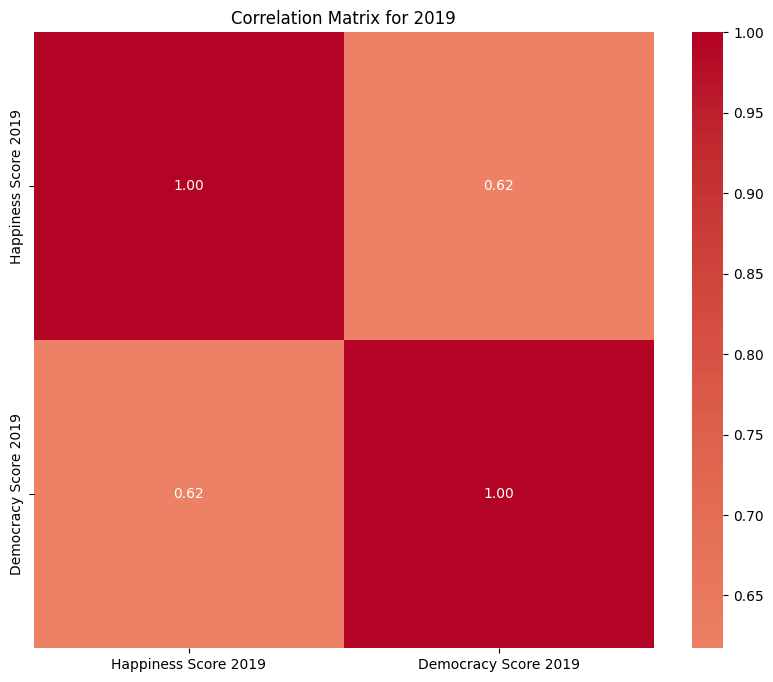

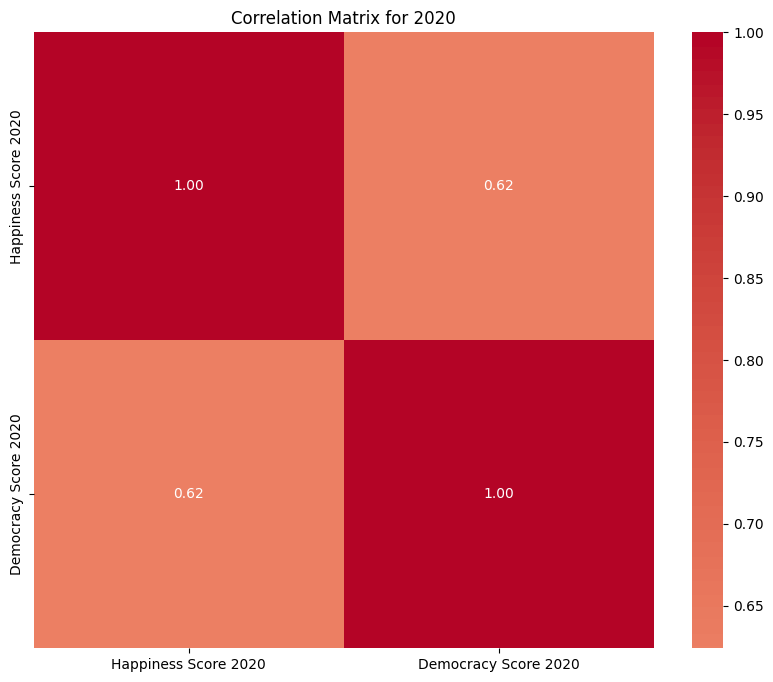

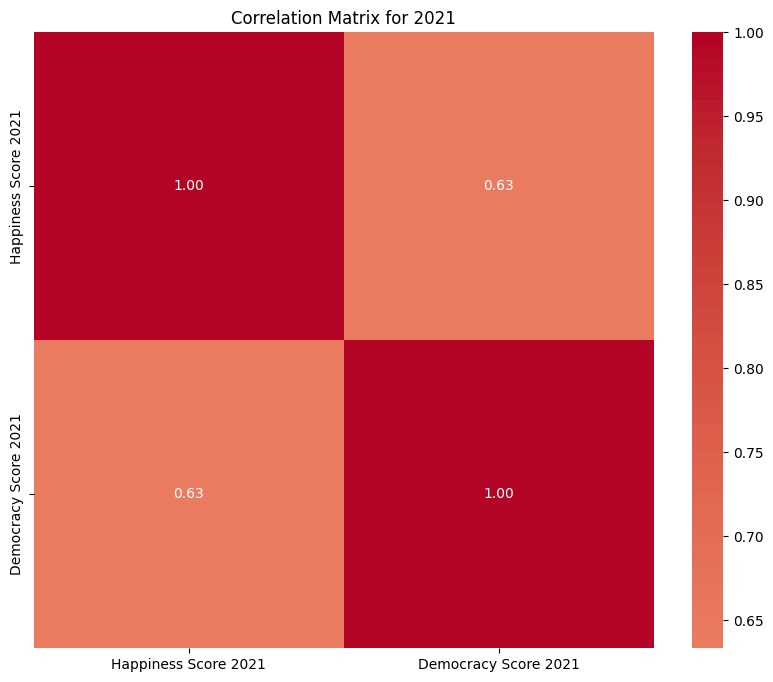

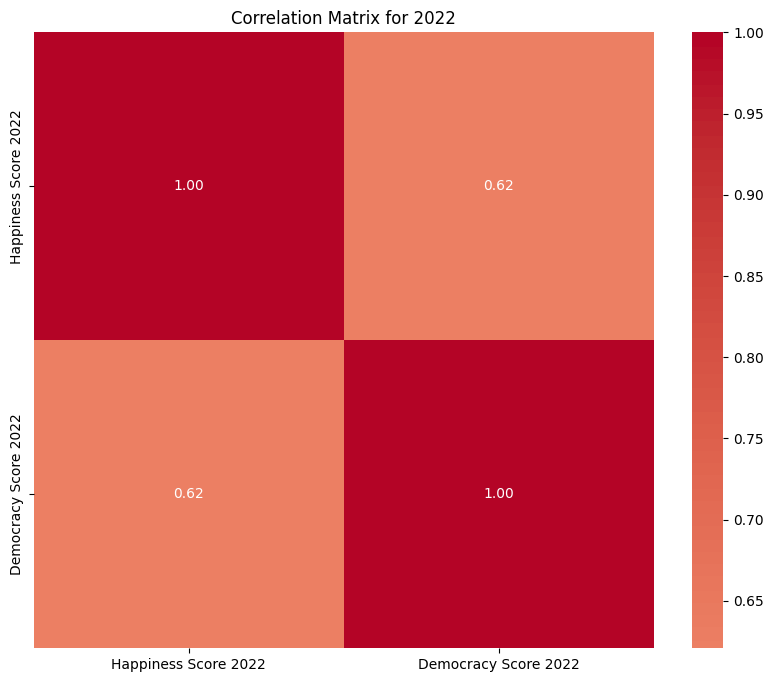

In [14]:
# Merge dataframes on the Country column
merged_df = pd.merge(happiness_df, dem_df, on='Country')

# Prepare a dataframe for correlation
corr_df = merged_df[['Country', 
                     'Happiness Score 2019', 'Happiness Score 2020', 'Happiness Score 2021', 'Happiness Score 2022',
                     'Democracy Score 2019', 'Democracy Score 2020', 'Democracy Score 2021', 'Democracy Score 2022']]

# Calculate correlation for each year
for year in range(2019, 2023):
    corr = corr_df[[f'Happiness Score {year}', f'Democracy Score {year}']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
    plt.title(f'Correlation Matrix for {year}')
    plt.show()


### Happiness & Democracy by Year - Scatter Plot (Visualization)

This interactive scatter plot represents the relationship between 'Happiness Score' and 'Democracy Score' for different countries over the years 2019 to 2022. The visualization enables a detailed comparison of the 'Happiness Score' and 'Democracy Score' for different countries. It also allows for an exploration of any potential correlation between these two factors and the extent of authoritarianism, as indicated by the 'Label' column.

We can see that there are four distinct clusters, which are the different authoritarian levels. From that we can also see that there seems to be a positive correlation in full-democracies between happiness and level of democracy - the higher the democracy score, the higher the level of happiness. After that, happiness seems to become more variable. Interestingly, the graph becomes more vertically spread out in 2020 and 2021, which are the COVID years, and that makes sense. We can see there that the datapoints are more spread out among Hybrid Regimes and Authoritarian Regimes in those years but then they seem to come back together into a tighter cluster in 2022. 

In [17]:
#reshape both dataframes to a long format
happiness_long = happiness_df.melt(id_vars='Country', var_name='Year', value_name='Happiness Score')
dem_long = dem_df.melt(id_vars=['Country', '2019 Label', '2020 Label', '2021 Label', '2022 Label'], var_name='Year', value_name='Democracy Score')

# Convert Year to integer for later comparison and merging
happiness_long['Year'] = happiness_long['Year'].str.extract('(\d+)').astype(int)
dem_long['Year'] = dem_long['Year'].str.extract('(\d+)').astype(int)

# Merge both dataframes
merged_df = pd.merge(happiness_long, dem_long,  how='inner', left_on=['Country','Year'], right_on = ['Country','Year'])

# Create a new column 'Label' to store the correct label for each year
merged_df['Label'] = merged_df.apply(lambda row: row[str(row['Year']) + ' Label'], axis=1)

# Now use Altair to create the chart
slider = alt.binding_range(min=2019, max=2022, step=1)
slider_selection = alt.selection_single(bind=slider, fields=['Year'], name="Select", init={'Year' : 2019})

scatter_plot = alt.Chart(merged_df).mark_circle(size=60).encode(
    x='Democracy Score',
    y='Happiness Score',
    tooltip=['Country', 'Democracy Score', 'Happiness Score'],
    color='Label',
    opacity=alt.condition(slider_selection, alt.value(1), alt.value(0.1))
).add_selection(
    slider_selection
).properties(
    width=600,
    height=400,
    title = "Happiness & Democracy Score by Year"
)

scatter_plot


alt.Chart(...)

### Happiness & Democracy by Year - Bar Chart (Visualization)

In every chart, the x-axis represents the 'Happiness Score' for the specified year, while the y-axis signifies the various countries, ordered in descending fashion based on the 'Happiness Score'. In addition, each bar is color-coded according to its 'Democracy Label' for the respective year, providing an additional layer of information regarding the democratic or authoritarian nature of the corresponding country. This facilitates an easy year-over-year comparison of happiness scores across the various countries, alongside their democracy labels.

This chart supports the previous visualization - that more democratic countries are happier than non-democratic countries. There's also a bit more variatino in colors in 2020 and 2021, which signifies that countries of different democracy levels had drastically different changes in their happiness levels. It's interesting to note that Israel slowly snuck up in happiness rankings each year. Furthermore, the authoritarian and hybrid regimes became less uniform in the bottom of the chart, indicating that they were less effective at recovering their citizens' happiness levels. 

In [18]:


# Merge the dataframes on 'Country'
merged_df = pd.merge(happiness_df, dem_df, on='Country')

# Create the horizontal bar charts for each year with all countries
charts = []
for year in range(2019, 2023):
    chart = alt.Chart(merged_df).mark_bar().encode(
        x=f'Happiness Score {year}:Q',
        y=alt.Y('Country:N', sort='-x'),
        color=alt.Color(f'{year} Label:N', legend=alt.Legend(title='Democracy Label')),
        tooltip=[alt.Tooltip("Country"), alt.Tooltip(f"Happiness Score {year}")]
    ).properties(
        title=f'Countries by Happiness Score in {year}',
        width=150,
        height=1500
    )
    charts.append(chart)

# Concatenate the charts horizontally
concatenated_chart = alt.hconcat(*charts)

# Display the concatenated chart
concatenated_chart


alt.HConcatChart(...)

### Happiness Shock vs. Democracy Level During 2019 (Visualization)

The x-axis represents the Democracy Score for each country in 2019, before COVID-19 had a global impact. A higher value indicates a more democratic country, while a lower value suggests a more authoritarian country. The y-axis represents the "Happiness Shock" that occurred from 2019 to 2020. This is calculated as the change in the Happiness Score from 2019 to 2020. A negative value indicates a decrease in happiness (i.e., a negative shock), and a positive value indicates an increase in happiness (i.e., a positive shock). Similar to previous visualizations, we acn see that the graph is clustered by regime type. Surprisingly, and I feel like this certainly needs more research, it seems that most countries actually got happier during covid, there are a lot less countries that had a negative happienss shock than I expected. 

We do see however, that there are smaller negative numbers with more authoritarian countries, this indicates that authoritarian governments were worse at controlling the happiness of their citizens in response to COVID. 

In [32]:
# Calculate happiness shock due to COVID-19
happiness_df['Happiness Shock'] = happiness_df['Happiness Score 2020'] - happiness_df['Happiness Score 2019']

# Merge the democracy and happiness dataframes for 2019
df = pd.merge(happiness_df[['Country', 'Happiness Shock']], dem_df[['Country', 'Democracy Score 2019', '2019 Label']], on='Country')

scatter_plot = alt.Chart(df).mark_circle(size=60).encode(
    x=alt.X('Democracy Score 2019:Q', title='Democracy Score 2019'),
    y=alt.Y('Happiness Shock:Q', title='Happiness Shock (2021 - 2019)'),
    color=alt.Color('2019 Label:N', legend=alt.Legend(title='Democracy Label 2019')),
    tooltip=['Country', 'Democracy Score 2019', 'Happiness Shock']
).properties(title = "Democracy Level vs. Happiness Shock").interactive()

scatter_plot


alt.Chart(...)

### Average Happiness Shock by Regime Type (Visualization)

This line chart visualizes the mean "happiness shock" experienced by different types of political systems to COVID. The x-axis represents different "democracy labels" from the year 2019. These labels classify countries according to their type of governance. The y-axis represents the mean "Happiness Shock" experienced by the countries in each democracy label category. The "Happiness Shock" is calculated as the change in happiness score from 2019 to 2020. Each point on the line represents a specific democracy label and the associated mean happiness shock. The line is connecting these points to illustrate the trend of the mean happiness shock across different democracy labels. A higher point means a larger average happiness shock (which could be a positive or negative change). On the x-axis, if the line is ascending from left to right, it means that countries with more democratic labels (as we move to the right on the x-axis) had a higher average happiness shock. If the line is descending, countries with less democratic labels experienced a higher average happiness shock.The actual position of the line in the y-axis (whether it's mostly above or below zero) will tell you if the shock was positive (increasing happiness from 2019 to 2020) or negative (decreasing happiness).



In [20]:
# Group by '2019 Label' and calculate the mean 'Happiness Shock'
mean_happiness_shock = df.groupby('2019 Label')['Happiness Shock'].mean().reset_index()

line_chart = alt.Chart(mean_happiness_shock).mark_line(point=True).encode(
    x=alt.X('2019 Label:N', title='Democracy Label 2019'),
    y=alt.Y('Happiness Shock:Q', title='Mean Happiness Shock (2020 - 2019)'),
    tooltip=['2019 Label', 'Happiness Shock']
).interactive()

line_chart


alt.Chart(...)

## Summary Through Choropleth Maps

### Import Choropleth Data & Clean

In [21]:
countries = pd.read_csv("Data/GeoJSONs/countries.csv")
countries_gdf = gpd.read_file('Data/GeoJSONs/countries.geojson')
countries_gdf = countries_gdf.rename(columns={'ADMIN':'Country'})
countries_gdf

,Country,ISO_A3,ISO_A2,geometry
0,Aruba,ABW,AW,"MULTIPOLYGON (((-69.99694 12.57758, -69.93639 ..."
1,Afghanistan,AFG,AF,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38..."
2,Angola,AGO,AO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,AI,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,AL,"MULTIPOLYGON (((19.74777 42.57890, 19.74601 42..."
...,...,...,...,...
250,Samoa,WSM,WS,"MULTIPOLYGON (((-171.57002 -13.93816, -171.564..."
251,Yemen,YEM,YE,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12..."
252,South Africa,ZAF,ZA,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -..."
253,Zambia,ZMB,ZM,"MULTIPOLYGON (((31.11984 -8.61663, 31.14102 -8..."


In [22]:
gpd_countries = set(countries_gdf['Country'])
countries = set(countries['Country'])
# Find the countries in gpd_countries that are not in the countries set
countries_not_in_set = gpd_countries - countries

print(countries_not_in_set)

{'Guam', 'American Samoa', 'Macedonia', 'Antarctica', 'US Naval Base Guantanamo Bay', 'Trinidad and Tobago', 'Northern Mariana Islands', 'Sint Maarten', 'Guinea Bissau', 'Macao S.A.R', 'Liechtenstein', 'Hong Kong S.A.R.', 'Fiji', 'Kiribati', 'Burundi', 'Scarborough Reef', 'Seychelles', 'Guernsey', 'Brunei', 'New Caledonia', 'Solomon Islands', 'Haiti', 'Marshall Islands', 'Maldives', 'Cyprus No Mans Area', 'Angola', 'British Virgin Islands', 'Falkland Islands', 'Djibouti', 'Palau', 'Republic of Congo', 'Turks and Caicos Islands', 'Belize', 'Dominica', 'Saint Helena', 'Norfolk Island', 'Suriname', 'Monaco', 'Puerto Rico', 'Bermuda', 'Montserrat', 'Saint Vincent and the Grenadines', 'Western Sahara', 'Barbados', 'The Bahamas', 'Samoa', 'United States Virgin Islands', 'Wallis and Futuna', 'United Republic of Tanzania', 'Federated States of Micronesia', 'Spratly Islands', 'South Georgia and South Sandwich Islands', 'Qatar', 'Anguilla', 'Aruba', 'Oman', 'Dhekelia Sovereign Base Area', 'Syria

In [23]:
replaces = {'Czech Republic':'Czechia', 
            'Republic of Congo': 'Congo',
            'United Republic of Tanzania':'Tanzania',
            'Northern Cyprus': 'Cyprus',
            'Swaziland' : 'Kingdom of Eswatini',
            'Republic of Serbia' : 'Serbia',
            'Palestine' : 'Palestinian Territories'}

removes = ['Suriname','United States Virgin Islands', 'Antigua and Barbuda',
           'Western Sahara','Belize','Puerto Rico',
           'US Naval Base Guantanamo Bay','Heard Island and McDonald Islands',
           'Pitcairn Islands', 'Clipperton Island','Sint Maarten', 
           'Spratly Islands', 'Papua New Guinea', 'North Korea', 
           'Saint Martin', 'Antarctica', 'Saint Barthelemy',
           'Sao Tome and Principe', 'Somaliland', 'Burundi', 'Solomon Islands', 
           'Brunei', 'Haiti','French Southern and Antarctic Lands', 
           'Federated States of Micronesia', 'Palau', 'Macao S.A.R', 'Djibouti', 'Macedonia', 'Dhekelia Sovereign Base Area', 'Siachen Glacier', 'Montserrat', 'Akrotiri Sovereign Base Area', 'Scarborough Reef', 'Barbados', 'Greenland', 'Cayman Islands', 'Northern Mariana Islands', 'Maldives', 'Curaçao', 'Ashmore and Cartier Islands','Sudan', 'Angola', 'Bermuda', 'Grenada', 'South Sudan', 'Eritrea', 'French Polynesia', 'Serranilla Bank', 'Saint Kitts and Nevis', 'Cape Verde', 'Vanuatu', 'Cyprus No Mans Area', 'Samoa', 'British Virgin Islands', 'Seychelles', 'Falkland Islands', 'Liechtenstein', 'Turks and Caicos Islands', 'Anguilla', 'Guinea Bissau', 'Tuvalu', 'Jersey', 'United States Minor Outlying Islands', 'Central African Republic', 'Bhutan', 'Bajo Nuevo Bank (Petrel Is.)', 'Oman', 'Cuba', 'Guyana', 'Saint Helena', 'Trinidad and Tobago', 'Taiwan', 'East Timor', 'Fiji', 'Guam', 'Saint Pierre and Miquelon', 'Wallis and Futuna', 'Democratic Republic of the Congo', 'Somalia', 'Marshall Islands', 'Baykonur Cosmodrome', 'Guernsey', 'South Georgia and South Sandwich Islands', 'Vatican', 'Cook Islands', 'New Caledonia', 'Gibraltar', 'Isle of Man', 'Nauru', 'Saint Lucia', 'Andorra', 'American Samoa', 'Faroe Islands', 'San Marino', 'Indian Ocean Territories', 'Norfolk Island', 'Equatorial Guinea', 'Saint Vincent and the Grenadines', 'Coral Sea Islands', 'Niue', 'Hong Kong S.A.R.', 'Monaco', 'Dominica', 'Qatar', 'Kiribati', 'The Bahamas', 'Syria', 'Tonga', 'Aland', 'British Indian Ocean Territory', 'Aruba' ]

In [24]:
# Replace values in the 'Entity' column using the replaces dictionary
countries_gdf['Country'] = countries_gdf['Country'].replace(replaces)

# Remove rows corresponding to the values in the removes list
countries_gdf = countries_gdf[~countries_gdf['Country'].isin(removes)]

countries_gdf.drop(['ISO_A3','ISO_A2'], axis=1, inplace=True)

In [25]:
countries_gdf

,Country,geometry
1,Afghanistan,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38..."
4,Albania,"MULTIPOLYGON (((19.74777 42.57890, 19.74601 42..."
7,United Arab Emirates,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24..."
8,Argentina,"MULTIPOLYGON (((-68.65412 -54.88624, -68.65414..."
9,Armenia,"MULTIPOLYGON (((45.54717 40.62155, 45.51369 40..."
...,...,...
246,Vietnam,"MULTIPOLYGON (((106.66871 8.75349, 106.66586 8..."
251,Yemen,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12..."
252,South Africa,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -..."
253,Zambia,"MULTIPOLYGON (((31.11984 -8.61663, 31.14102 -8..."


In [26]:
# Merge happiness data so we can look at the different levels of happiness in different countries across different years
happiness_countries_merged_df = countries_gdf.merge(happiness_df, on='Country', how = 'right')

happiness_countries_merged_df

,Country,geometry,Happiness Score 2019,Happiness Score 2020,Happiness Score 2021,Happiness Score 2022,Happiness Shock
0,Finland,"MULTIPOLYGON (((22.44370 59.85147, 22.42774 59...",7.769,7.8087,7.842,7.821,0.0397
1,Denmark,"MULTIPOLYGON (((11.25603 54.95458, 11.30348 54...",7.600,7.6456,7.620,7.636,0.0456
2,Norway,"MULTIPOLYGON (((3.38258 -54.44931, 3.36451 -54...",7.554,7.4880,7.392,7.365,-0.0660
3,Iceland,"MULTIPOLYGON (((-20.26964 63.40913, -20.27953 ...",7.494,7.5045,7.554,7.557,0.0105
4,Netherlands,"MULTIPOLYGON (((-68.23729 12.02680, -68.24254 ...",7.488,7.4489,7.464,7.415,-0.0391
...,...,...,...,...,...,...,...
138,Yemen,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12...",3.380,3.5274,3.658,4.197,0.1474
139,Rwanda,"MULTIPOLYGON (((30.47179 -1.06684, 30.46386 -1...",3.334,3.3123,3.415,3.268,-0.0217
140,Tanzania,"MULTIPOLYGON (((39.74916 -8.06549, 39.71944 -8...",3.231,3.4762,3.623,3.702,0.2452
141,Afghanistan,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38...",3.203,2.5669,2.523,2.404,-0.6361


### Happiness Choropleth Map (Visualization)

The visualization is an interactive choropleth map displaying countries' happiness scores over the years 2019 through 2022. Brighter colors means higher levels of happiness while darker colors means lower levels of happiness. If we assume that western countries are "more democratic" and easter countries are "more authoritarian", we can see that the west became less happy while the east became more happy. This might indicate that citizens in "more authoritarian" countries became happier after COVID. 

In [27]:
# Convert the GeoDataFrame to a long format DataFrame
happiness_long_df = happiness_countries_merged_df.melt(
    id_vars=['Country', 'geometry'],
    value_vars=['Happiness Score 2019', 'Happiness Score 2020', 
                'Happiness Score 2021', 'Happiness Score 2022'],
    var_name='Year',
    value_name='Happiness Score'
)

# Extract the year from the Year column
happiness_long_df['Year'] = happiness_long_df['Year'].str.extract('(\d+)').astype(int)

# Use the data_server provider to allow Altair to work with the GeoDataFrame directly
alt.data_transformers.register('data_server', data_server)
alt.data_transformers.enable('data_server')

# Define the base chart
base_chart = alt.Chart(happiness_long_df).mark_geoshape(
    stroke='black',
    strokeWidth=0.5
).encode(
    tooltip=[
        alt.Tooltip('Country:N', title='Country'),
    ]
).project('equirectangular')

# Create a list of years for which you have happiness scores
years = [2019, 2020, 2021, 2022]

# Create a slider for selecting the year
year_slider = alt.binding_range(min=years[0], max=years[-1], step=1)
slider_selection = alt.selection_single(bind=year_slider, fields=['Year'], name='Select', init={'Year': years[0]})

# Define the choropleth map using the year slider
map_chart = base_chart.add_selection(
    slider_selection
).transform_filter(
    slider_selection
).encode(
    color=alt.Color('Happiness Score:Q', title='Happiness Score', scale=alt.Scale(scheme='viridis')),
    tooltip=[
        alt.Tooltip('Country:N', title='Country'),
        alt.Tooltip('Happiness Score:Q', title='Happiness Score')
    ]
).properties(
    title="Happiness Score by Country",
    width = 800, 
    height = 600
)

# Display the map
map_chart


alt.Chart(...)

### Democracy Choropleth Map (Visualization)
This choropleth map depicts the level of democracy across all countries between 2019 and 2022. We can see that generally, western countries are considered more democratic thatn eastern nations. Darker colors means more authoritarian while lighter colors mean more democratic. We actually see that, in general democracy levels decreased throughout the world. 

In [28]:
democracy_merged = countries_gdf.merge(dem_df, on='Country', how='right')
# Convert the GeoDataFrame to a long format DataFrame
democracy_long_df = democracy_merged.melt(
    id_vars=['Country','geometry'],
    value_vars=['Democracy Score 2019', 'Democracy Score 2020', 'Democracy Score 2021','Democracy Score 2022'],
    var_name='Year',
    value_name='Democracy Score'
)

# Extract the year from the Year column
democracy_long_df['Year'] = democracy_long_df['Year'].str.extract('(\d+)').astype(int)

# Use the data_server provider to allow Altair to work with the GeoDataFrame directly
alt.data_transformers.register('data_server', data_server)
alt.data_transformers.enable('data_server')

# Define the base chart
base_chart = alt.Chart(democracy_long_df).mark_geoshape(
    stroke='black',
    strokeWidth=0.5
).encode(
    tooltip=[
        alt.Tooltip('Entity:N', title='Country'),
    ]
).project('equirectangular')

# Create a list of years for which you have happiness scores
years = [2019, 2020, 2021, 2022]

# Create a slider for selecting the year
year_slider = alt.binding_range(min=years[0], max=years[-1], step=1)
slider_selection = alt.selection_single(bind=year_slider, fields=['Year'], name='Select', init={'Year': years[0]})

# Define the choropleth map using the year slider
map_chart = base_chart.add_selection(
    slider_selection
).transform_filter(
    slider_selection
).encode(
    color=alt.Color('Democracy Score:Q', title='Democracy Score', scale=alt.Scale(scheme='viridis')),
    tooltip=[
        alt.Tooltip('Country:N', title='Country'),
        alt.Tooltip('Democracy Score:Q', title='Democracy Score')
    ]
).properties(
    title="Democracy Score by Country",
    width = 800, 
    height = 600
)

# Display the map
map_chart


alt.Chart(...)

### Change in Happiness from 2019 - 2022 (Visualization)

This visualization shows us how much countries were affected and whether or not they were able to recover from COVID. The previous visualization confirmed our assumption that western countries are "more democratic" and easter countries are "more authoritarian." We Actually see that, in general, the colors across the world are relatively similar. This would indicate that it doesn't matter too much whether the country is "more democratic" or "more authoritarian."

In [29]:
merged_df = happiness_df[['Country','Happiness Shock']].merge(dem_df[['Country','Democracy Score 2021', '2021 Label']], on = 'Country')

# Merge GeoDataFrame with merged_df
merged_gdf = countries_gdf.merge(merged_df, on='Country', how='right')

# Define the base chart
base_chart = alt.Chart(merged_gdf).mark_geoshape(
    stroke='black',
    strokeWidth=0.5
).encode(
    tooltip=[
        alt.Tooltip('Country:N', title='Country'),
        alt.Tooltip('Democracy Score 2021:Q', title='Democracy Score 2021'),
        alt.Tooltip('2021 Label:N', title='2021 Democracy Label')
    ]
).project('equirectangular')

# Define the choropleth map
map_chart = base_chart.encode(
    color=alt.Color('Happiness Shock:Q', title='Happiness Shock 2020-2021', scale=alt.Scale(scheme='viridis')),
    tooltip=[
        alt.Tooltip('Country:N', title='Country'),
        alt.Tooltip('Happiness Shock:Q', title='Happiness Change 2020-2021'),
        alt.Tooltip('Democracy Score 2021:Q', title='Democracy Score 2021'),
        alt.Tooltip('2021 Label:N', title='2021 Democracy Label')
    ]
).properties(
    title="Change in Happiness Scores from 2019 to 2020",
    width = 800, 
    height = 600
)

# Display the map
map_chart


alt.Chart(...)

### Countries Most Heavily Affected by Covid (Visualization)
This visualization is a side-by-side bar chart representation of countries that experienced the most significant positive and negative happiness shocks between 2020 and 2021. The first chart, `positive_chart`, displays the countries with the most significant positive happiness shocks. The x-axis represents the magnitude of the happiness shock, and the y-axis represents the corresponding countries, sorted in descending order of the happiness shock. Each bar is color-coded according to its 'Democracy Label' for 2021, offering further context. Similarly, the `negative_chart` depicts countries that experienced the most considerable negative happiness shocks, with countries sorted in ascending order of the happiness shock.The resulting dual-chart visualization enables a clear comparison of the countries that experienced the most significant positive and negative happiness shocks between 2020 and 2021, factoring in their respective democracy levels.

This is actually pretty conflicting data, because it's showing that all types of regimes except for full democracies were impacted most heavily in both directions. 

In [30]:
merged_df = happiness_df[['Country','Happiness Shock']].merge(dem_df[['Country','Democracy Score 2021', '2021 Label']], on = 'Country')

# Merge GeoDataFrame with merged_df
merged_gdf = countries_gdf.merge(merged_df, on='Country', how='right')

# Separate positive and negative shocks
positive_shocks_df = merged_gdf[merged_gdf['Happiness Shock'] >= 0].sort_values(by='Happiness Shock', ascending=False)
negative_shocks_df = merged_gdf[merged_gdf['Happiness Shock'] < 0].sort_values(by='Happiness Shock')

# Top N countries with most positive and negative shocks
N = 10
positive_shocks_df = positive_shocks_df.head(N)
negative_shocks_df = negative_shocks_df.head(N)

# Create the Altair charts
positive_chart = alt.Chart(positive_shocks_df).mark_bar().encode(
    x=alt.X('Happiness Shock:Q', title='Happiness Shock 2020-2021'),
    y=alt.Y('Country:N', sort='-x', title='Country'),
    color=alt.Color('2021 Label:N', legend=alt.Legend(title='Democracy Label')),
    tooltip=[
        alt.Tooltip('Country:N', title='Country'),
        alt.Tooltip('Democracy Score 2021:N', title = 'Democracy Score'),
        alt.Tooltip('2021 Label:N', title = 'Democracy Level')
    ]
).properties(
    title="Top "+str(N)+" Countries with Most Positive Happiness Shocks"
)

negative_chart = alt.Chart(negative_shocks_df).mark_bar().encode(
    x=alt.X('Happiness Shock:Q', title='Happiness Shock 2020-2021'),
    y=alt.Y('Country:N', sort='x', title='Country'),
    color=alt.Color('2021 Label:N', legend=alt.Legend(title='Democracy Label')),
    tooltip=[
        alt.Tooltip('Country:N', title='Country'),
        alt.Tooltip('Democracy Score 2021:N', title = 'Democracy Score'),
        alt.Tooltip('2021 Label:N', title = 'Democracy Level')
    ]
).properties(
    title="Top "+str(N)+" Countries with Most Negative Happiness Shocks"
)

# Concatenate the charts
combined_chart = alt.hconcat(positive_chart, negative_chart).resolve_scale(
    x='independent'
)

combined_chart


alt.HConcatChart(...)

### Happiness Shocks Sorted by Magnitude (Visualization)

This visualization depcits the magnitude of happiness shocks across all countries between 2020 and 2021. The x-axis represents the 'Happiness Shock' magnitude, while the y-axis lists the countries, sorted in descending order based on the happiness shock. Each bar is color-coded according to its '2021 Label', presumably indicating the regime type for each country, offering additional insight. It's interesting to see that the impact is about half and half. 

In [31]:
# Calculate happiness shocks across all countries
shocks_df = merged_gdf.sort_values(by='Happiness Shock', ascending=False)

# Define the Altair chart
chart = alt.Chart(shocks_df).mark_bar().encode(
    x=alt.X('Happiness Shock:Q', title='Happiness Shock 2020-2021'),
    y=alt.Y('Country:N', sort='-x', title='Country'),
    color=alt.Color('2021 Label:N', legend=alt.Legend(title='Regime Type')),
    tooltip=[
        alt.Tooltip('Country:N', title='Country'),
        alt.Tooltip('Democracy Score 2021:N', title = 'Democracy Score'),
        alt.Tooltip('Happiness Shock:Q', title = 'Happiness Shock'),
        alt.Tooltip('2021 Label:N', title = 'Regime Type')
    ]
).properties(
    title="Countries and Happiness Shocks Sorted by Magnitude"
)

# Display the chart
chart


alt.Chart(...)